In [1]:
# Cell 1 – Setup
!pip install duckdb pandas datasets transformers peft accelerate

import duckdb
import pandas as pd
import textwrap


In [2]:
# Cell 2 – Load CSV into DuckDB

csv_path = "/content/drive/MyDrive/Credit Card Data.csv"  # your 1.3M-row file

con = duckdb.connect("transactions.duckdb")

# Load directly from CSV
con.execute(f"""
    CREATE TABLE IF NOT EXISTS transactions AS
    SELECT *
    FROM read_csv_auto('{csv_path}', HEADER=TRUE)
""")

# Quick check
print(con.execute("SELECT COUNT(*) FROM transactions").fetchall())
print(con.execute("PRAGMA table_info('transactions')").fetchdf())


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[(1296675,)]
    cid                   name       type  notnull dflt_value     pk
0     0             Unnamed: 0     BIGINT    False       None  False
1     1  trans_date_trans_time  TIMESTAMP    False       None  False
2     2                 cc_num     BIGINT    False       None  False
3     3               merchant    VARCHAR    False       None  False
4     4               category    VARCHAR    False       None  False
5     5                    amt     DOUBLE    False       None  False
6     6                  first    VARCHAR    False       None  False
7     7                   last    VARCHAR    False       None  False
8     8                 gender    VARCHAR    False       None  False
9     9                 street    VARCHAR    False       None  False
10   10                   city    VARCHAR    False       None  False
11   11                  state    VARCHAR    False       None  False
12   12                    zip     BIGINT    False       None  False
13   13              

In [3]:
# Cell 3 – Inspect value ranges to generate realistic questions

df_sample = con.execute("""
    SELECT cc_num, MIN(trans_date_trans_time) AS min_dt, MAX(trans_date_trans_time) AS max_dt
    FROM transactions
    GROUP BY cc_num
    LIMIT 1000
""").fetchdf()

df_sample.head()


,cc_num,min_dt,max_dt
0,503848303379,2019-01-01 10:30:25,2020-06-21 07:34:12
1,4681601008538160,2019-01-01 08:59:40,2020-06-21 11:32:55
2,3512365128314616,2019-01-01 20:26:27,2020-06-20 21:12:16
3,180069253480336,2019-01-01 04:59:12,2020-06-21 05:30:26
4,3521815216091574,2019-01-01 03:37:43,2020-06-21 09:49:31


In [4]:
# Cell 4 – Generate (question, sql) pairs

import random
from datetime import datetime

def random_date_range(min_dt, max_dt):
    # DuckDB will probably give strings; adjust if they’re timestamps
    min_ts = pd.to_datetime(min_dt)
    max_ts = pd.to_datetime(max_dt)
    if min_ts >= max_ts:
        return min_ts, max_ts
    # choose 2 random dates in range
    t1 = min_ts + (max_ts - min_ts) * random.random()
    t2 = min_ts + (max_ts - min_ts) * random.random()
    start, end = sorted([t1, t2])
    return start.date().isoformat(), end.date().isoformat()

def q_total_spent_by_card_and_range(row):
    card = int(row["cc_num"])
    start, end = random_date_range(row["min_dt"], row["max_dt"])
    question = (
        f"What is the total amount spent by card {card} "
        f"between {start} and {end}?"
    )
    sql = textwrap.dedent(f"""
        SELECT SUM(amt) AS total_amount
        FROM transactions
        WHERE cc_num = {card}
          AND trans_date_trans_time >= '{start}'
          AND trans_date_trans_time < '{end}';
    """).strip()
    return question, sql

def q_top_merchants_for_card(card):
    question = f"Which merchants has card {card} spent the most money at?"
    sql = textwrap.dedent(f"""
        SELECT merchant, SUM(amt) AS total_spent
        FROM transactions
        WHERE cc_num = {card}
        GROUP BY merchant
        ORDER BY total_spent DESC
        LIMIT 10;
    """).strip()
    return question, sql

def q_fraud_rate_by_category():
    question = "What is the fraud rate by transaction category?"
    sql = textwrap.dedent("""
        SELECT category,
               AVG(is_fraud::DOUBLE) AS fraud_rate,
               COUNT(*) AS total_txn
        FROM transactions
        GROUP BY category
        ORDER BY fraud_rate DESC;
    """).strip()
    return question, sql


In [5]:
# Cell 5 – Build training records

records = []

for _, row in df_sample.iterrows():
    q, s = q_total_spent_by_card_and_range(row)
    records.append({"question": q, "sql": s, "type": "card_total"})

    q, s = q_top_merchants_for_card(int(row["cc_num"]))
    records.append({"question": q, "sql": s, "type": "top_merchants"})

# Add some global-style questions
for _ in range(300):
    q, s = q_fraud_rate_by_category()
    records.append({"question": q, "sql": s, "type": "fraud_rate_category"})

len(records), records[0]


(2266,
 {'question': 'What is the total amount spent by card 503848303379 between 2019-08-13 and 2020-01-27?',
  'sql': "SELECT SUM(amt) AS total_amount\nFROM transactions\nWHERE cc_num = 503848303379\n  AND trans_date_trans_time >= '2019-08-13'\n  AND trans_date_trans_time < '2020-01-27';",
  'type': 'card_total'})

In [6]:
# Cell 6 – Convert to a text field for training

from datasets import Dataset

def format_example(ex):
    # You can tweak this prompt later
    return {
        "text": textwrap.dedent(f"""
        ### Instruction:
        You are an assistant that writes SQL queries for DuckDB.
        Given the schema below and the user's question, write a valid SQL query.

        ### Schema:
        Table transactions(
            row_index INT,
            trans_date_trans_time TIMESTAMP,
            cc_num BIGINT,
            merchant TEXT,
            category TEXT,
            amt DOUBLE,
            first TEXT,
            last TEXT,
            gender TEXT,
            street TEXT,
            city TEXT,
            state TEXT,
            zip INT,
            lat DOUBLE,
            long DOUBLE,
            city_pop INT,
            job TEXT,
            dob DATE,
            trans_num TEXT,
            unix_time BIGINT,
            merch_lat DOUBLE,
            merch_long DOUBLE,
            is_fraud INT,
            merch_zipcode INT
        )

        ### Question:
        {ex['question']}

        ### Response (SQL only):
        {ex['sql']}
        """).strip()
    }

ds = Dataset.from_list(records)
ds = ds.map(format_example)
ds = ds.remove_columns([c for c in ds.column_names if c != "text"])
ds_train = ds.shuffle(seed=42)
ds_train


Map:   0%|          | 0/2266 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 2266
})

In [7]:
# Cell 7 – Load model + tokenizer with 4-bit quantization (optional but helpful)

!pip install bitsandbytes

from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

model_name = "Qwen/Qwen2.5-3B-Instruct"  # or another small instruct model

tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_4bit=True,
    device_map="auto"
)

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],  # adjust per model if needed
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 44.0 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

trainable params: 7,372,800 || all params: 3,093,311,488 || trainable%: 0.2383


In [8]:
# Cell 8 – Tokenize dataset

max_length = 1024  # queries+SQL are short; this is fine

def tokenize_function(examples):
    tokenized_inputs = tokenizer(
        examples["text"],
        truncation=True,
        max_length=max_length,
        padding="max_length"
    )
    # For causal language modeling, labels are usually the input_ids
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()
    return tokenized_inputs

tokenized_ds = ds_train.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

tokenized_ds = tokenized_ds.train_test_split(test_size=0.05, seed=42)
tokenized_ds

Map:   0%|          | 0/2266 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2152
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 114
    })
})

In [9]:
# Cell 9 – TrainingArguments + Trainer

output_dir = "nl2sql-cc-finetuned"

# Upgrade accelerate to ensure compatibility with the installed transformers version.
# An old accelerate version can cause issues with TrainingArguments.
!pip install --upgrade accelerate

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=0.5,
    learning_rate=2e-4,
    warmup_steps=50,
    logging_steps=50,
    save_steps=500,
    eval_steps=500,
    fp16=True,
    report_to="none",
    lr_scheduler_type="cosine",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
)

trainer.train()
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
50,2.890500


('nl2sql-cc-finetuned/tokenizer_config.json',
 'nl2sql-cc-finetuned/special_tokens_map.json',
 'nl2sql-cc-finetuned/chat_template.jinja',
 'nl2sql-cc-finetuned/vocab.json',
 'nl2sql-cc-finetuned/merges.txt',
 'nl2sql-cc-finetuned/added_tokens.json',
 'nl2sql-cc-finetuned/tokenizer.json')

In [10]:
# Cell 10 – Load fine-tuned model for inference

from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch

ft_model_name = output_dir  # the folder you just saved

# Load the original base model with 4-bit quantization
# Do not use device_map="auto" here to avoid offloading conflicts during adapter loading
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_4bit=True,
)

# Load the PEFT adapter weights
model = PeftModel.from_pretrained(model, ft_model_name)

# Merge the adapter weights into the base model for inference
# This makes the model a standard HF model again, easier to handle device placement
model = model.merge_and_unload()

# Now load the tokenizer and move the merged model to GPU
tokenizer = AutoTokenizer.from_pretrained(ft_model_name)
model.to('cuda') # or specify a specific device if needed

model.eval()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
The tokenizer you are loading from 'nl2sql-cc-finetuned' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e.  This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-35): 36 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=True)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=True)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm

In [11]:
# Cell 11 – NL -> SQL generation

SCHEMA_TEXT = """
Table transactions(
    row_index INT,
    trans_date_trans_time TIMESTAMP,
    cc_num BIGINT,
    merchant TEXT,
    category TEXT,
    amt DOUBLE,
    first TEXT,
    last TEXT,
    gender TEXT,
    street TEXT,
    city TEXT,
    state TEXT,
    zip INT,
    lat DOUBLE,
    long DOUBLE,
    city_pop INT,
    job TEXT,
    dob DATE,
    trans_num TEXT,
    unix_time BIGINT,
    merch_lat DOUBLE,
    merch_long DOUBLE,
    is_fraud INT,
    merch_zipcode INT
)
"""

def build_prompt(question: str) -> str:
    return textwrap.dedent(f"""
    ### Instruction:
    You are an assistant that writes SQL queries for DuckDB.
    Only output a single SQL query, nothing else.

    ### Schema:
    {SCHEMA_TEXT}

    ### Question:
    {question}

    ### Response (SQL only):
    """).strip()

def generate_sql(question: str, max_new_tokens: int = 256) -> str:
    prompt = build_prompt(question)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=0.0,
            pad_token_id=tokenizer.eos_token_id,
        )
    full_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    # Extract everything after the last marker
    if "### Response (SQL only):" in full_text:
        sql_part = full_text.split("### Response (SQL only):")[-1].strip()
    else:
        sql_part = full_text.strip()
    # Optional: strip backticks and trailing commentary
    sql_part = sql_part.split(";")[0].strip() + ";"
    return sql_part


In [12]:
# Cell 12 – Execute generated SQL on DuckDB

def query_agent(question: str):
    sql = generate_sql(question)
    print("Generated SQL:\n", sql)

    try:
        df = con.execute(sql).fetchdf()
    except Exception as e:
        print("SQL execution error:", e)
        df = pd.DataFrame()

    return sql, df

# Example:
q = "Show the top 5 merchants by total fraud amount."
sql, df = query_agent(q)
df.head()


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated SQL:
 SELECT first, last, SUM(amt) AS total_fraud
    FROM transactions
    WHERE is_fraud = 1
    GROUP BY first, last
    ORDER BY total_fraud DESC
    LIMIT 5;


,first,last,total_fraud
0,Jennifer,Scott,14319.39
1,Scott,Martin,13656.63
2,Micheal,Walters,12011.59
3,Susan,Garcia,11457.11
4,Charles,Preston,11061.27


In [13]:
# Optional – simple Gradio app

!pip install gradio

import gradio as gr

def gradio_interface(question):
    sql, df = query_agent(question)
    return sql, df

demo = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Textbox(label="Ask about your transactions"),
    outputs=[
        gr.Textbox(label="Generated SQL"),
        gr.Dataframe(label="Result")
    ],
    title="Credit Card Transactions Query Assistant"
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4d47351d3d8fb41b41.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [14]:
# Cell 13 – (run once) Install Gradio + Matplotlib
!pip install gradio matplotlib --quiet


In [15]:
# Cell 14 – Extra imports for viz + Gradio

import matplotlib.pyplot as plt
import gradio as gr
from pandas.api.types import is_numeric_dtype, is_datetime64_any_dtype


In [16]:
# Cell 15 – Heuristics to choose chart type and build a matplotlib figure

def choose_axes(df: pd.DataFrame, question: str):
    """
    Decide which columns to plot (x, y) based on NL question + df.
    Returns (x_col, y_col, chart_type) or (None, None, None) if can't decide.

    chart_type in {"line", "bar", "scatter"}.
    """
    if df.empty or df.shape[1] == 0:
        return None, None, None

    cols = list(df.columns)

    # Look for time-related phrasing in the question
    q_lower = question.lower()
    time_keywords = [
        "over time", "by day", "by month", "by year",
        "trend", "time series", "daily", "monthly"
    ]
    is_time_question = any(k in q_lower for k in time_keywords)

    # Identify numeric, datetime, and "categorical" columns
    numeric_cols = [c for c in cols if is_numeric_dtype(df[c])]
    datetime_cols = [c for c in cols if is_datetime64_any_dtype(df[c])]
    cat_cols = [
        c for c in cols
        if df[c].dtype == "object" or str(df[c].dtype).startswith("category")
    ]

    # If user is asking for a trend but we don't have datetime dtype,
    # try to parse datetime-like columns.
    if is_time_question and not datetime_cols:
        for c in cols:
            if "date" in c.lower() or "time" in c.lower():
                try:
                    df[c] = pd.to_datetime(df[c])
                    datetime_cols.append(c)
                except Exception:
                    pass

    # 1) Time series: datetime x numeric y → line chart
    if is_time_question and datetime_cols and numeric_cols:
        x_col = datetime_cols[0]
        candidate_numeric = [c for c in numeric_cols if "id" not in c.lower()]
        y_col = candidate_numeric[0] if candidate_numeric else numeric_cols[0]
        return x_col, y_col, "line"

    # 2) Categorical vs numeric → bar chart
    if cat_cols and numeric_cols:
        x_col = cat_cols[0]
        candidate_numeric = [c for c in numeric_cols if c != x_col]
        y_col = candidate_numeric[0] if candidate_numeric else numeric_cols[0]
        return x_col, y_col, "bar"

    # 3) Two numeric columns → scatter plot
    if len(numeric_cols) >= 2:
        x_col, y_col = numeric_cols[0], numeric_cols[1]
        return x_col, y_col, "scatter"

    # fallback: no clear visualization
    return None, None, None


def create_plot(df: pd.DataFrame, question: str):
    """
    Create a matplotlib figure based on df + natural-language question.
    Returns a figure or None if plotting doesn't make sense.
    """
    if df is None or df.empty:
        return None

    x_col, y_col, chart_type = choose_axes(df, question)
    if x_col is None or y_col is None or chart_type is None:
        return None

    # Limit rows to keep plots light-weight
    df_plot = df[[x_col, y_col]].dropna().copy()
    if df_plot.empty:
        return None

    max_points = 500
    if len(df_plot) > max_points:
        df_plot = df_plot.sample(max_points, random_state=42)

    fig, ax = plt.subplots()

    if chart_type == "line":
        df_plot = df_plot.sort_values(by=x_col)
        ax.plot(df_plot[x_col], df_plot[y_col])
    elif chart_type == "bar":
        # Aggregate categories if there are many of them
        if df_plot[x_col].nunique() > 20:
            df_agg = df_plot.groupby(x_col, as_index=False)[y_col].sum()
            df_agg = df_agg.sort_values(by=y_col, ascending=False).head(20)
        else:
            df_agg = df_plot
        ax.bar(df_agg[x_col], df_agg[y_col])
        ax.set_xticklabels(df_agg[x_col], rotation=45, ha="right")
    elif chart_type == "scatter":
        ax.scatter(df_plot[x_col], df_plot[y_col])

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(question)
    fig.tight_layout()
    return fig


In [17]:
# Cell 16 – Extended agent that includes visualization

def query_agent_with_viz(question: str):
    """
    Natural language → SQL → DuckDB → (DataFrame, matplotlib Figure).

    Returns: sql, df, fig, error_message
    """
    if not question.strip():
        return "", pd.DataFrame(), None, "Please enter a question."

    # NL -> SQL
    try:
        sql = generate_sql(question)
    except Exception as e:
        return "", pd.DataFrame(), None, f"Error generating/cleaning SQL: {e}"

    # Execute SQL on DuckDB
    try:
        df = con.execute(sql).fetchdf()
    except Exception as e:
        return sql, pd.DataFrame(), None, f"SQL execution error: {e}"

    # Build visualization (if possible)
    try:
        fig = create_plot(df, question)
    except Exception as e:
        fig = None
        err_msg = f"Query ran, but failed to create visualization: {e}"
        return sql, df, fig, err_msg

    # No errors
    return sql, df, fig, ""


SQL: SELECT category, AVG(is_fraud) AS fraud_rate FROM transactions WHERE is_fraud = 1 GROUP BY category ORDER BY fraud_rate DESC;
Error: 


/tmp/ipython-input-3631322916.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_agg[x_col], rotation=45, ha="right")


,category,fraud_rate
0,shopping_net,1.0
1,food_dining,1.0
2,personal_care,1.0
3,grocery_pos,1.0
4,home,1.0


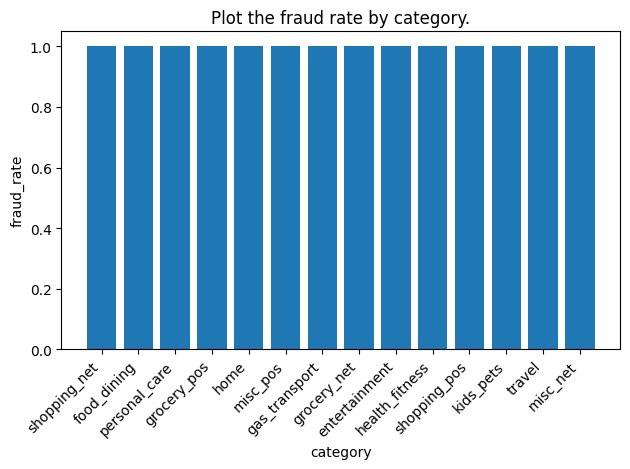

In [18]:
# Quick smoke test (optional)
sql, df, fig, err = query_agent_with_viz("Plot the fraud rate by category.")
print("SQL:", sql)
print("Error:", err)
df.head()


In [19]:
# Cell 17 – Gradio UI: NL → SQL → Table + Visualization

example_questions = [
    "Show the top 10 merchants by total transaction amount and plot them.",
    "Plot the fraud rate by transaction category.",
    "Show daily total fraud amount over time.",
    "Compare average transaction amount by state and visualize it.",
    "Plot the relationship between transaction amount and city population."
]

with gr.Blocks(title="Credit Card Transactions NL→SQL + Visualization") as demo:
    gr.Markdown("# 💳 Credit Card Transactions Query & Visualization Assistant")
    gr.Markdown(
        "Ask questions in plain English. The assistant will:\n"
        "1. Generate SQL for DuckDB,\n"
        "2. Run it on your 1.3M-row dataset,\n"
        "3. Show the table result and an automatic chart when possible."
    )

    with gr.Row():
        question_box = gr.Textbox(
            label="Your question",
            placeholder="e.g., Plot the fraud rate by category.",
            lines=2
        )

    with gr.Row():
        run_btn = gr.Button("Run query")

    with gr.Row():
        sql_box = gr.Textbox(
            label="Generated SQL",
            interactive=False
        )

    with gr.Row():
        result_df = gr.Dataframe(
            label="Query result",
            interactive=False
        )

    with gr.Row():
        plot_out = gr.Plot(label="Visualization")

    error_box = gr.Markdown()

    def on_submit(q):
        sql, df, fig, err = query_agent_with_viz(q)
        if df is None:
            df = pd.DataFrame()
        err_text = f"**Error:** {err}" if err else ""
        return sql, df, fig, err_text

    run_btn.click(
        fn=on_submit,
        inputs=[question_box],
        outputs=[sql_box, result_df, plot_out, error_box]
    )

    gr.Examples(
        examples=example_questions,
        inputs=[question_box],
        outputs=[sql_box, result_df, plot_out, error_box],
        fn=on_submit,
        cache_examples=False
    )

# In Colab, use share=True if you want a public link:
demo.launch()          # or demo.launch(share=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4addc81cb3bac46a46.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
